# Understanding mental health concepts derived from CBT

This project is aimed at understanding and diagnosing mental health status using concepts from (CBT) Cognitive Behavioural Theory. There are 15 thinking errors, 10 emotions and 7 situations that have been taken into account for the project. I have built my own dataset and used back translation for increasing the training sample count. Further details can be found in the report.

In [1]:
import pandas as pd
import tensorflow as tf
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras import layers
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [3]:
class CBT():
    def __init__(self):
        self.MAX_SEQUENCE_LENGTH = 250
        self.EMBEDDING_DIM = 100
        self.MAX_NB_WORDS = 50000
        
        self.labels = {0:['Sample','Samples'],
                      1:['Situation','Situations'],
                      2:['Emotion','Emotions'],
                      3:['Thinking_Error','Thinking Error']}
        
        self.filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'
    
    def readData(self,path = 'Try3.csv'):
        data = pd.read_csv(path)
        display(data.head())
        return data
    
    def plotData(self,data):
        for i in range(1,len(self.labels)):
            data[self.labels[i][0]].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Samples', title=self.labels[i][1]) 
    
    def preProcess(self,data):
        #Finding unique tokens in the corpora using tokenization
        # The maximum number of words to be used. (most frequent)
        tokenizer = Tokenizer(num_words=self.MAX_NB_WORDS, filters=self.filters, lower=True)
        for i in range(len(self.labels)):
            tokenizer.fit_on_texts(data[self.labels[i][0]].values)
            word_index = tokenizer.word_index
            
        X = tokenizer.texts_to_sequences(data[self.labels[0][0]].values)
        X = pad_sequences(X, maxlen=self.MAX_SEQUENCE_LENGTH)
        Y = {}
        for i in range(1,len(self.labels)):
            Y[self.labels[i][1]] = pd.get_dummies(data[self.labels[i][0]]).values
        return X,Y,tokenizer,self.labels
    
    def buildModel(self,input_shape,OP_Dim, embedding_dim):
        model = keras.Sequential()
        model.add(Embedding(self.MAX_NB_WORDS, embedding_dim, input_length=input_shape))
        model.add(SpatialDropout1D(0.2))
        model.add(LSTM(100,dropout = 0.2, recurrent_dropout = 0.2, return_sequences = False))
        model.add(Dense(OP_Dim, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.summary()
        return model
    
    def train(self,model,X_train,Y_train,epochs,batch_size):
        history = model.fit(X_train, Y_train, 
                            epochs=epochs, 
                            batch_size=batch_size,
                            validation_split=0.1,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
        return history, model
    
    def evaluateModels(self,ModelStack,DataGen):
        testAcc = []
        for i in range(1,len(self.labels)):
            accr = ModelStack[self.labels[i][1]][1].evaluate(DataGen[self.labels[i][1]][0],DataGen[self.labels[i][1]][1])
            print(self.labels[i][1],': Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
            testAcc.append(accr[1])
        return testAcc
    
    def plotLogs(self,ModelStack):
        plt.figure(figsize=(15,20))
        k = 1
        for i in range(1,len(self.labels)):
            plt.subplot(3,2,k)
            plt.title("Loss vs Epochs - " + (str)(self.labels[i][1]))
            plt.plot(ModelStack[self.labels[i][1]][0].history['loss'],label = "Training")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.plot(ModelStack[self.labels[i][1]][0].history['val_loss'],label = "Validation")
            plt.legend()
            k+=1
            plt.subplot(3,2,k)
            plt.title("Accuracy vs Epochs - " + (str)((self.labels[i][1])))
            plt.plot(ModelStack[self.labels[i][1]][0].history['accuracy'],label = "Training")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.plot(ModelStack[self.labels[i][1]][0].history['val_accuracy'],label = "Validation")
            plt.xlabel("Epochs")
            plt.legend()
            k+=1
        plt.show()
    
    def infer(self,ModelStack,tokenizer,infer_labels,DataGen):
        
        Predicted = {}
        for i in range(1,len(self.labels)):
            model_OP = []
            for j in range(len(DataGen[self.labels[i][1]][0])):
                pred = ModelStack[self.labels[i][1]][1].predict(DataGen[self.labels[i][1]][0][j].reshape(1,self.MAX_SEQUENCE_LENGTH))
                val = (np.argmax(pred,axis=1))[0]
                model_OP.append(str(infer_labels[i-1][val]))
            Predicted[self.labels[i][1]] = model_OP
        
        Final_Inference = pd.DataFrame(tokenizer.sequences_to_texts((DataGen[self.labels[i][1]][0])))
        
        for i in range(1,len(infer_labels)+1):
            YY = infer_labels[i-1]
            Test = []
            for j in range(len(DataGen[self.labels[i][1]][0])):
                Test.append((YY[(np.argmax(DataGen[self.labels[i][1]][1][j]))]))
            col_a = self.labels[i][1] + ' (actual)'
            col_p = self.labels[i][1] + ' (predicted)'
            Final_Inference[col_a] = Test
            Final_Inference[col_p] = Predicted[self.labels[i][1]]
        display(Final_Inference)
        

In [4]:
predictors = 3
OP_Dim =[]
epochs = 10
batch_size = 10
therapy = CBT()
path_default = r'data/Try3.csv'
try:
    path = input("Enter Data path: ")
    data = therapy.readData(path)
except FileNotFoundError:
    print("Incorrect path entered. Using default path")
    path = path_default
    data = therapy.readData()

Enter Data path: 
Incorrect path entered. Using default path


,Sample,Thinking_Error,Emotion,Situation
0,"I just feel too lonely at school, home, and ev...",Catastrophising,Loneliness,Work
1,"I feel lonely at school, at home, and everywhe...",Catastrophising,Loneliness,Work
2,"I just feel too lonely at school, at home and ...",Catastrophising,Loneliness,Work
3,I’m depressed everywhere just because I feel l...,Catastrophising,Loneliness,Work
4,"I'm just too lonely at school, at home and eve...",Catastrophising,Loneliness,Work


In [5]:
therapy.plotData(data)

In [6]:
X,Y,tokenizer,labels = therapy.preProcess(data)
input_shape = X.shape[1]

Infer_labels=[]
for i in range(1,len(labels)):
    Infer_labels.append(list(pd.get_dummies(data[labels[i][0]]).columns))

for i in range(1,len(labels)):
    OP_Dim.append((np.unique(data[labels[i][0]])))                 

print("Model compilation complete")
print('-'*30)
print("\nTraining the model now\n")
print('-'*30)

Model compilation complete
------------------------------

Training the model now

------------------------------


In [7]:
DataGen = {}
ModelStack = {}
embedding_dims = [100, 100, 100]
for i in range(1,len(labels)):
    model = therapy.buildModel(input_shape,OP_Dim[i-1].shape[0], embedding_dims[i-1])
    X_train, X_unseen, Y_train, Y_unseen = train_test_split(X,Y[labels[i][1]], test_size = 0.10, random_state = 42)
    logs, model = therapy.train(model,X_train,Y_train,epochs,batch_size)
    ModelStack[labels[i][1]] = [logs, model]
    DataGen[labels[i][1]] = [X_unseen, Y_unseen]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 6)                 606       
Total params: 5,081,006
Trainable params: 5,081,006
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
39/39 [==============================] - 63s 1s/step - loss: 1.6694 - accuracy: 0.3375 - val_loss: 1.5023 - val_accuracy: 0.4318
Epoch 2/10
39/39 [==============================] - 52s 1s/step - loss: 1.4695 - accuracy: 0.3940 - val_

In [9]:
lstm_test = therapy.evaluateModels(ModelStack,DataGen)

2/2 [==============================] - 0s 96ms/step - loss: 0.3098 - accuracy: 0.9388
Situations : Test set
  Loss: 0.310
  Accuracy: 0.939
2/2 [==============================] - 0s 96ms/step - loss: 0.3852 - accuracy: 0.9184
Emotions : Test set
  Loss: 0.385
  Accuracy: 0.918
2/2 [==============================] - 0s 117ms/step - loss: 0.4263 - accuracy: 0.8980
Thinking Error : Test set
  Loss: 0.426
  Accuracy: 0.898


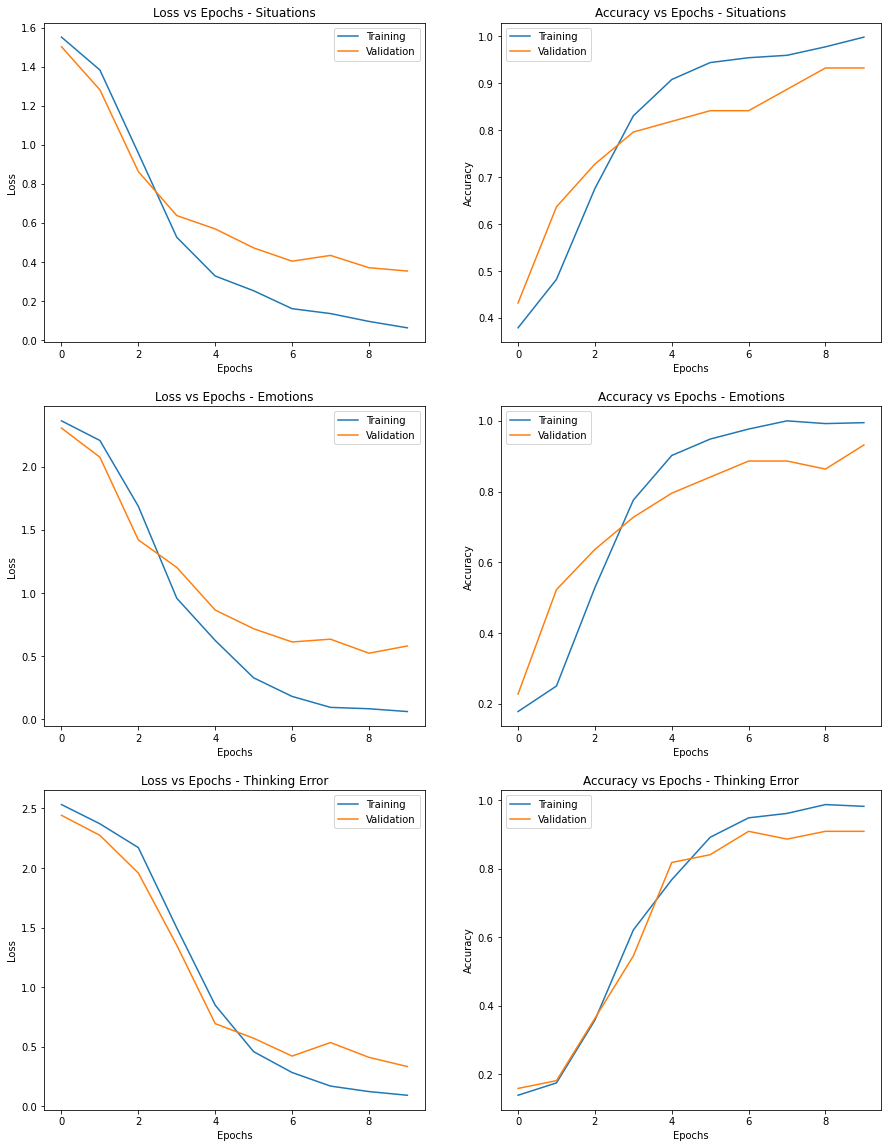

In [10]:
therapy.plotLogs(ModelStack)

In [13]:
therapy.infer(ModelStack,tokenizer,Infer_labels,DataGen)

,0,Situations (actual),Situations (predicted),Emotions (actual),Emotions (predicted),Thinking Error (actual),Thinking Error (predicted)
0,every day there are funerals that i mourn for ...,Other,Other,Guilt,Guilt,Comparing,Comparing
1,joy is a state of mind and i have not experien...,Life,Life,Grief,Grief,Emotional Reasoning,Emotional Reasoning
2,i have no one to converse with when i have all...,Work,Work,Frustration,Frustration,Emotional Reasoning,Emotional Reasoning
3,i'm being bullied by everyone,Life,Life,Hurt,Hurt,Over-generalizing,Over-generalizing
4,i have a nice family friends but i don’t feel ...,Existential,Existential,Anger,Anger,Loneliness,Loneliness
5,life is all but sad,Life,Life,Grief,Grief,Black and White,Black and White
6,with the burden of all these difficulties inse...,Work,Work,Frustration,Frustration,Emotional Reasoning,Emotional Reasoning
7,i’m just distressed and stuck with a disorder ...,Life,Life,Depression,Depression,Labelling,Labelling
8,every day is a funeral i mourn my old self,Other,Other,Guilt,Guilt,Comparing,Comparing
9,i am deprived of love since my childhood,Bereavement,Bereavement,Grief,Grief,Blaming,Black and White


In [14]:
from sklearn import svm
models_test = []
models_acc = []
for i in range(1,len(labels)):
    
    X_train, X_unseen, Y_train, Y_unseen = train_test_split(X,Y[labels[i][1]], test_size = 0.10, random_state = 42)
    clf = svm.SVC()
    clf.fit(X_train, np.argmax(Y_train, axis = 1))
    models_acc.append(clf.score(X_train, np.argmax(Y_train, axis = 1)))
    models_test.append(clf.score(X_unseen, np.argmax(Y_unseen, axis = 1)))
    print(labels[i][1], "Train Acc: {:0.2f} Test Acc: {:0.2f}".format(models_acc[-1]*100, models_test[-1]*100))

Situations Train Acc: 60.42 Test Acc: 48.98
Emotions Train Acc: 51.39 Test Acc: 28.57
Thinking Error Train Acc: 48.84 Test Acc: 28.57


In [15]:
lstm_train = []
for i in range(1,4):
    lstm_train.append(ModelStack[labels[i][1]][0].history['accuracy'][-1])

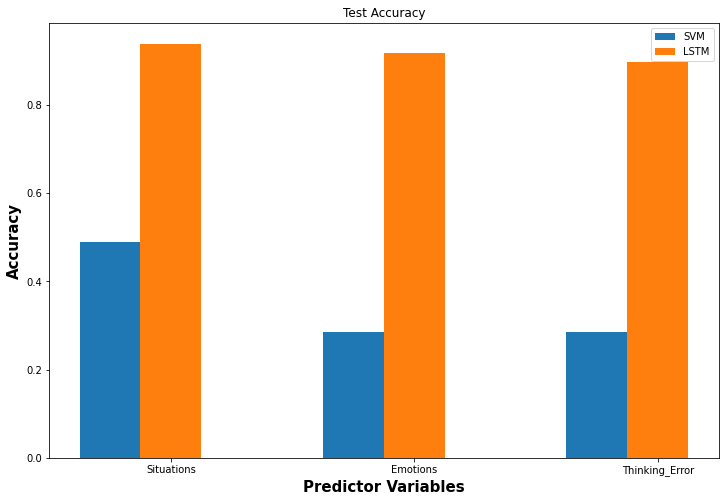

In [16]:
import numpy as np
import matplotlib.pyplot as plt

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]

plt.bar(br1, models_test, width = barWidth, label = 'SVM')
plt.bar(br2, lstm_test, width = barWidth, label = 'LSTM')

plt.xlabel('Predictor Variables', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],['Situations', 'Emotions', 'Thinking_Error'])

plt.legend()
plt.title('Test Accuracy')
plt.show()

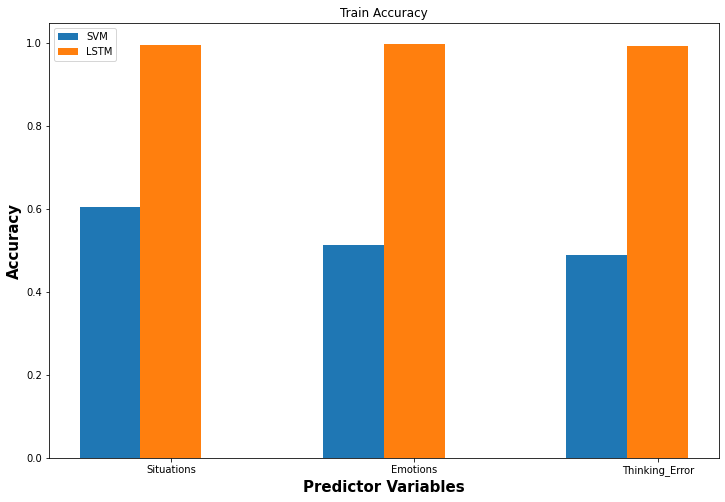

In [18]:
import numpy as np
import matplotlib.pyplot as plt

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
plt.bar(br1, models_acc, width = barWidth, label = 'SVM')
plt.bar(br2, lstm_train, width = barWidth, label = 'LSTM')
plt.xlabel('Predictor Variables', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],['Situations', 'Emotions', 'Thinking_Error'])
plt.legend()
plt.title('Train Accuracy')
plt.show()